OBEJCT DETECTION

TABLA DE CONTENIDO

1. DESC. problema

<a name="2"></a>
## <b> <font color='red'> 2. Modules </font>  </b>

In [1]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.layers import Conv2D, Reshape

import os
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import warnings

# Ignorar todos los warnings
warnings.filterwarnings('ignore')






2024-03-06 19:11:13.749892: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 19:11:13.788159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 19:11:13.788192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 19:11:13.789469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 19:11:13.795435: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 19:11:13.795934: I tensorflow/core/platform/cpu_feature_guard.cc:1

<a name="3"></a>
## <b> <font color='red'> 3. Helper Functions </font>  </b>

In [2]:
# plotting utilities




def plot_image_and_label(image_path, label): 
    """
    Imprime una imagen junto con su caja delimitadora
    
    Params:
    - image_path: ruta a la imagen
    - label: corrdenadas de la caja delimitadora (ya escaladas según el tamaño de la imagen)
    
    """
    image = preprocess_image(image_path)
    # Crear un objeto figura y ejes
    fig, ax = plt.subplots()
    # Mostrar la imagen
    ax.imshow(image)
    # Definir las coordenadas y dimensiones de la bounding box
    x, y, w, h = label['bbox'] #label[0:4] # 
    # Crear un rectángulo que representa la bounding box
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
    # Añadir el rectángulo al eje
    ax.add_patch(rect)
    # Mostrar la imagen con la bounding box
    plt.show()



In [3]:

# Función para escalar las coordenadas de la bounding box
def scaling_coordinates(coord, width, height, resized_width, resized_height):
    x, y, w, h = coord
    scale_x = resized_width / width
    scale_y = resized_height / height
    x_scaled = int(x * scale_x)
    y_scaled = int(y * scale_y)
    w_scaled = int(w * scale_x)
    h_scaled = int(h * scale_y)
    return [x_scaled, y_scaled, w_scaled, h_scaled]
    
    
# image size (width, height and channels)
def get_image_size(image_path):
    # Cargar la imagen
    image = cv2.imread(image_path)
    # Obtener el tamaño de la imagen
    height, width, channels = image.shape
    return width, height, channels


# Ejemplo de preprocesamiento de imágenes y etiquetas
def preprocess_image(image_path):
    # Cargar la imagen y redimensionarla
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224)) # resize mantiene los canales de color! 
    #  Normalizar los valores de píxeles al rango [0, 1]
    image = image / 255.0  
    return image


# Función para leer las anotaciones XML y extraer las coordenadas de las cajas delimitadoras
def parse_annotation(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    # Extraer la etiqueta 'object' que contiene la información de la caja delimitadora
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        # Retornar las coordenadas de la caja delimitadora y la etiqueta
        return xmin, ymin, xmax, ymax, name
    


    
    



In [4]:
#Voy a crear un one-hot encoding para las clases

# debemos convertir las clases a one-hot
# Obtener todas las clases únicas
unique_classes = ['banana', 'apple', 'orange']

# Crear un diccionario de codificación one-hot
one_hot_encoding = {class_name: [0] * len(unique_classes) for class_name in unique_classes}
for i, class_name in enumerate(unique_classes):
    one_hot_encoding[class_name][i] = 1
    
    
one_hot_encoding

{'banana': [1, 0, 0], 'apple': [0, 1, 0], 'orange': [0, 0, 1]}

### Pre-processing

Vamos a:

- Convertir las etiquetas de clases usando one-hot encoding
- Escalar apropiadamente las etiquetas de caja delimitadora, pues están en coordenadas absolutas
y rescalamos la imagen

In [5]:
# load path to images and annotations
def load_data_from_annotation(images_dir, annotations_dir, one_hot_encoding=one_hot_encoding):
    # Listas para almacenar los nombres de archivos de imágenes y las etiquetas de las cajas delimitadoras
    images = []
    labels = []

    # Iterar sobre los archivos de anotaciones en el directorio de anotaciones
    for annotation_file in os.listdir(annotations_dir):
        if annotation_file.endswith('.xml'):
            annotation_path = os.path.join(annotations_dir, annotation_file)
            image_name = annotation_file.replace('.xml', '.jpg')  # Obtener el nombre de la imagen correspondiente
            image_path = os.path.join(images_dir, image_name)


            # Leer las coordenadas de la caja delimitadora y la etiqueta
            xmin, ymin, xmax, ymax, label = parse_annotation(annotation_path)
            # scaling
            width, height, _ = get_image_size(image_path)
            xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled = scaling_coordinates([xmin, ymin, xmax, ymax], 
                                                                                     width, height, 224, 224)



            # Agregar la imagen y las etiquetas a las listas correspondientes
            images.append(image_path)
            #labels.append([xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled, label])
            labels.append({'bbox': [xmin_scaled, ymin_scaled, xmax_scaled, ymax_scaled], 
                           'class': one_hot_encoding[label]})
            
    return images, labels

In [6]:
# hacer notebook explicando el pre-procesamiento en detalle

<a name="4"></a>
## <b> <font color='red'> 4. Loading, exploring and pre-processing data </font>  </b>

In [7]:
# Directorio de las imágenes y anotaciones
train_images_dir = 'data/train'
train_annotations_dir = 'data/train'


val_images_dir = 'data/test'
val_annotations_dir = 'data/test'



In [8]:
train_images, train_labels = load_data_from_annotation(train_images_dir, train_annotations_dir)


val_images, val_labels = load_data_from_annotation(val_images_dir, val_annotations_dir)

# Verificar los datos obtenidos
#print("Nombres de archivos de imágenes:", train_images)
print("Etiquetas de las cajas delimitadoras:", train_labels[3],train_labels[4])




libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Etiquetas de las cajas delimitadoras: {'bbox': [0, 48, 220, 213], 'class': [1, 0, 0]} {'bbox': [63, 10, 208, 206], 'class': [0, 1, 0]}


In [9]:
val_images[2], val_labels[2]

('data/test/banana_86.jpg', {'bbox': [53, 25, 158, 210], 'class': [1, 0, 0]})

Vemos que train_images son los paths a las imágenes y que train_labels está compuesto por las coordenadas de la caja delimitadora y la clase.


### Plot image

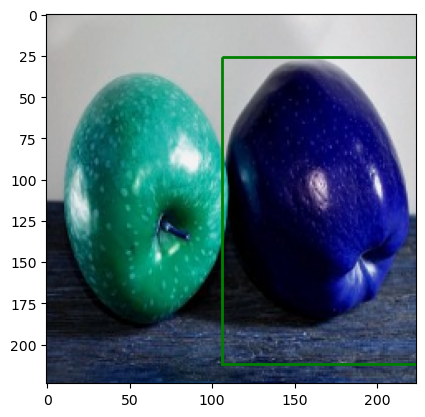

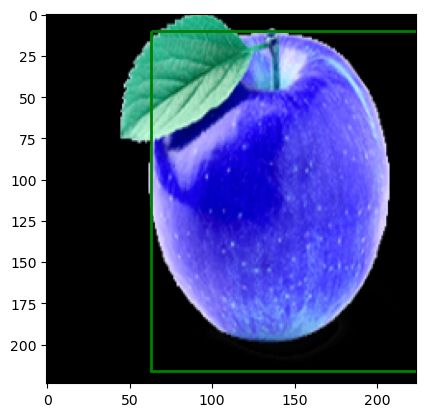

In [10]:
plot_image_and_label(train_images[8], train_labels[8])
plot_image_and_label(train_images[4], train_labels[4])

In [11]:
train_labels[2:4]

[{'bbox': [17, 24, 199, 212], 'class': [0, 1, 0]},
 {'bbox': [0, 48, 220, 213], 'class': [1, 0, 0]}]

### Creamos el dataset

In [12]:
# pre-procesamiento de las imágenes
images = [preprocess_image(path) for path in train_images]

# Convertir las coordenadas de las cajas delimitadoras a tensores
bounding_boxes = tf.constant([obj['bbox'] for obj in train_labels], dtype=tf.float32)

# Convertir las clases a tensores
classes = tf.constant([obj['class'] for obj in train_labels], dtype=tf.float32) # labels

# Crear un diccionario de tensores
dataset_labels = {'bbox': bounding_boxes, 'class': classes}

# Crear el conjunto de datos
dataset = tf.data.Dataset.from_tensor_slices((images, dataset_labels))

# Define el tamaño del batch y mezcla los datos
BATCH_SIZE = 32
dataset = dataset.batch(BATCH_SIZE).shuffle(buffer_size=len(images))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
2024-03-06 19:11:37.401499: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 289013760 exceeds 10% of free system memory.


In [ ]:
for x,y in dataset:
    print(x, y)
    break

Repetimos para el conjunto de validación

In [16]:
# pre-procesamiento de las imágenes
val_images = [preprocess_image(path) for path in val_images]

# Convertir las coordenadas de las cajas delimitadoras a tensores
val_bounding_boxes = tf.constant([obj['bbox'] for obj in val_labels], dtype=tf.float32)

# Convertir las clases a tensores
val_classes = tf.constant([obj['class'] for obj in val_labels], dtype=tf.float32) # labels

# Crear un diccionario de tensores
val_dataset_labels = {'bbox': val_bounding_boxes, 'class': val_classes}

# Crear el conjunto de datos
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_dataset_labels))

# Define el tamaño del batch y mezcla los datos
BATCH_SIZE = 32
validation_dataset = val_dataset.batch(BATCH_SIZE).shuffle(buffer_size=len(images))

libpng warning: iCCP: known incorrect sRGB profile


<a name="5"></a>
## <b> <font color='red'> 5. Build, compile and train model </font>  </b>

In [13]:
num_classes = 3

In [14]:
# Definir la arquitectura de la CNN
input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(pool2)
flatten = tf.keras.layers.Flatten()(conv3)
dense1 = tf.keras.layers.Dense(64, activation='relu')(flatten)
output_class = tf.keras.layers.Dense(num_classes, activation='softmax', name='class')(dense1)
output_bbox = tf.keras.layers.Dense(4, activation='linear', name='bbox')(dense1)  # 4 coordenadas para la caja delimitadora

# Construir el modelo
model = tf.keras.Model(inputs=input_layer, outputs=[output_class, output_bbox]) #, output_bbox

# Compilar el modelo con diferentes métricas y funciones de pérdida para cada salida
model.compile(optimizer='adam',
              loss={'class': 'categorical_crossentropy', 'bbox': 'mse'},
              metrics={'class': 'accuracy', 'bbox': 'mae'})

# Resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d[0][0]']   

In [38]:
# Entrenar el modelo
history = model.fit(
        dataset,
        validation_data=validation_dataset,
        epochs=50)

Epoch 1/50
8/8 [==============================] - 8s 972ms/step - loss: 950.9746 - class_loss: 1.9731 - bbox_loss: 949.0016 - class_accuracy: 0.6333 - bbox_mae: 23.8390 - val_loss: 1155.8617 - val_class_loss: 1.8827 - val_bbox_loss: 1153.9790 - val_class_accuracy: 0.6500 - val_bbox_mae: 25.8690
Epoch 2/50
8/8 [==============================] - 8s 969ms/step - loss: 890.0123 - class_loss: 1.8181 - bbox_loss: 888.1942 - class_accuracy: 0.6208 - bbox_mae: 23.0806 - val_loss: 1205.5559 - val_class_loss: 3.2493 - val_bbox_loss: 1202.3065 - val_class_accuracy: 0.5500 - val_bbox_mae: 25.8434
Epoch 3/50
8/8 [==============================] - 8s 977ms/step - loss: 878.5419 - class_loss: 2.5658 - bbox_loss: 875.9760 - class_accuracy: 0.6250 - bbox_mae: 22.9322 - val_loss: 1134.1351 - val_class_loss: 2.3474 - val_bbox_loss: 1131.7877 - val_class_accuracy: 0.6000 - val_bbox_mae: 25.3600
Epoch 4/50
8/8 [==============================] - 8s 968ms/step - loss: 794.5751 - class_loss: 1.7951 - bbox_los

Epoch 29/50
8/8 [==============================] - 8s 962ms/step - loss: 110.5423 - class_loss: 0.4345 - bbox_loss: 110.1078 - class_accuracy: 0.8917 - bbox_mae: 7.8025 - val_loss: 1204.3302 - val_class_loss: 1.3511 - val_bbox_loss: 1202.9791 - val_class_accuracy: 0.8000 - val_bbox_mae: 26.4376
Epoch 30/50
8/8 [==============================] - 8s 979ms/step - loss: 117.1349 - class_loss: 0.4135 - bbox_loss: 116.7214 - class_accuracy: 0.9125 - bbox_mae: 8.2022 - val_loss: 1240.4065 - val_class_loss: 1.4977 - val_bbox_loss: 1238.9088 - val_class_accuracy: 0.8000 - val_bbox_mae: 26.5117
Epoch 31/50
8/8 [==============================] - 8s 1s/step - loss: 135.9655 - class_loss: 0.3735 - bbox_loss: 135.5920 - class_accuracy: 0.9000 - bbox_mae: 8.9242 - val_loss: 1323.4940 - val_class_loss: 1.5307 - val_bbox_loss: 1321.9633 - val_class_accuracy: 0.8000 - val_bbox_mae: 27.3600
Epoch 32/50
8/8 [==============================] - 8s 972ms/step - loss: 96.2702 - class_loss: 0.3717 - bbox_loss: 

<a name="6"></a>
## <b> <font color='red'> 6. Making predictions </font>  </b>

In [20]:


test_image_path = 'data/test_images/banana1.png'

test_image = preprocess_image(test_image_path)

In [23]:
test_image.shape

(224, 224, 3)

In [21]:
model.predict(test_image)

ValueError: in user code:

    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/marcos/.local/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 224, 3)


In [24]:
imagen_expandida = np.expand_dims(test_image, axis=0)


In [39]:
preds = model.predict(imagen_expandida)

1/1 [==============================] - 0s 32ms/step


In [40]:
preds

[array([[1.0000000e+00, 1.2198491e-14, 1.2027336e-15]], dtype=float32),
 array([[ 17.520931,  52.61604 , 209.5892  , 187.06972 ]], dtype=float32)]

In [41]:
preds[0], preds[1]

(array([[1.0000000e+00, 1.2198491e-14, 1.2027336e-15]], dtype=float32),
 array([[ 17.520931,  52.61604 , 209.5892  , 187.06972 ]], dtype=float32))

0


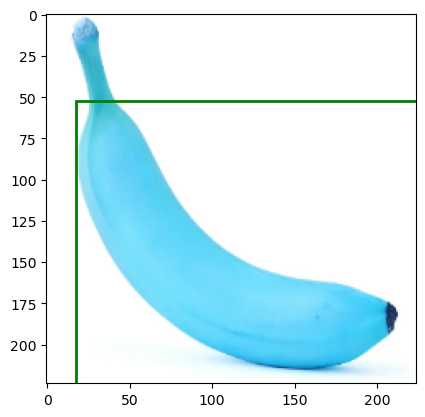

In [44]:

aux = {'bbox':[ 17.520931,  52.61604 , 209.5892  , 187.06972 ]}

clase_predicha = np.argmax(preds[0])
print(clase_predicha)

plot_image_and_label(test_image_path, aux)

In [ ]:
test_image_path = 'data/test_images/banana1.png'
test_image = preprocess_image(test_image_path)
imagen_expandida = np.expand_dims(test_image, axis=0)
preds = model.predict(imagen_expandida)

# escribir funciópn predict


In [31]:
one_hot_encoding

{'banana': [1, 0, 0], 'apple': [0, 1, 0], 'orange': [0, 0, 1]}

In [ ]:
# Labels para un solo objeto (por ejemplo, un perro)
label = {
    'class': 'perro',
    'bbox': [x_min, y_min, x_max, y_max]
}



# Labels para múltiples objetos
labels = [
    {
        'class': 'perro',
        'bbox': [x_min1, y_min1, x_max1, y_max1]
    },
    {
        'class': 'gato',
        'bbox': [x_min2, y_min2, x_max2, y_max2]
    },
    # Otros objetos...
]

Cuando redimensionas una imagen y también necesitas ajustar las coordenadas de las cajas delimitadoras (bounding boxes), es importante comprender cómo afecta esto al proceso de detección de objetos. La ubicación de la caja delimitadora en relación con la imagen es crucial para la precisión de la detección. Aquí hay algunos puntos importantes a considerar:

Coordenadas Relativas vs. Absolutas:

Las coordenadas de las cajas delimitadoras pueden ser relativas o absolutas.
Las coordenadas relativas son proporcionales al tamaño de la imagen. Por ejemplo, (0.5, 0.5) significaría el centro de la imagen.
Las coordenadas absolutas son específicas del tamaño de la imagen original. Por ejemplo, (100, 100) podría ser la esquina superior izquierda de una imagen de 200x200 píxeles.
Impacto del Resize:

Si redimensionas la imagen, las coordenadas de las cajas delimitadoras también deben ajustarse en consecuencia para mantener la coherencia en la detección de objetos.
Si las coordenadas de las cajas delimitadoras están en formato relativo, no necesitas ajustarlas siempre que el método de redimensionamiento conserve las proporciones de la imagen.
Si las coordenadas son absolutas, deberás escalarlas de acuerdo con el factor de redimensionamiento aplicado a la imagen.
Métodos de Redimensionamiento:

Algunos métodos de redimensionamiento pueden conservar mejor la relación de aspecto de la imagen que otros. Es preferible utilizar métodos que preserven la relación de aspecto para evitar distorsiones.
Precaución con las Transformaciones No Lineales:

Algunas transformaciones no lineales, como la distorsión geométrica, pueden alterar significativamente las formas y proporciones de los objetos en la imagen, lo que hace que las cajas delimitadoras redimensionadas sean menos precisas.
En resumen, cuando redimensionas una imagen para el procesamiento, es fundamental ajustar adecuadamente las coordenadas de las cajas delimitadoras para mantener la precisión de la detección de objetos. Esto se logra ajustando las coordenadas de las cajas delimitadoras en proporción al cambio en las dimensiones de la imagen.

In [ ]:
import numpy as np

# Tamaño de las imágenes redimensionadas
resized_width = 224
resized_height = 224

# Datos de las bounding boxes y clases
bounding_boxes_data = [
    [39, 55, 445, 474, 'apple'],
    [39, 55, 445, 400, 'banana']
    # Agrega más datos según sea necesario
]

# Función para escalar las coordenadas de la bounding box
def escalar_coordenadas(coord, width, height):
    x, y, w, h = coord
    scale_x = resized_width / width
    scale_y = resized_height / height
    x_scaled = int(x * scale_x)
    y_scaled = int(y * scale_y)
    w_scaled = int(w * scale_x)
    h_scaled = int(h * scale_y)
    return [x_scaled, y_scaled, w_scaled, h_scaled]

# Escalar coordenadas y convertir clases a one-hot
datos_preprocesados = []
clases = set()

for box_data in bounding_boxes_data:
    coord_escala = escalar_coordenadas(box_data[:4], box_data[2], box_data[3])
    clase = box_data[4]
    clases.add(clase)

    # Convertir la clase a one-hot
    one_hot_clase = [0] * len(clases)
    one_hot_clase[list(clases).index(clase)] = 1

    datos_preprocesados.append(coord_escala + one_hot_clase)

datos_preprocesados = np.array(datos_preprocesados)

print("Datos preprocesados:")
print(datos_preprocesados)


In [ ]:
import cv2

# Cargar la imagen
image = cv2.imread(train_images[1])

# Obtener el tamaño de la imagen
height, width, channels = image.shape

print("Ancho de la imagen:", width)
print("Alto de la imagen:", height)
print("Canales de color:", channels)